# Шапка с библиотеками

In [6]:
!pip install pmdarima

  Obtaining dependency information for numpy>=1.21.2 from https://files.pythonhosted.org/packages/3f/6b/5610004206cf7f8e7ad91c5a85a8c71b2f2f8051a0c0c4d5916b76d6cbb2/numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\gusev\\anaconda3\\Lib\\site-packages\\~~mpy.libs\\libscipy_openblas64_-43e11ff0749b8cbe0a615c9cf6737e0e.dll'
Consider using the `--user` option or check the permissions.



In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import pymannkendall as mk
import pmdarima as pm

from scipy import stats
import statsmodels.stats.diagnostic as stat
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as bgtest
from sklearn.metrics import mean_squared_error as mse


import matplotlib.dates as mdates
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

C:\Users\gusev\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# критерий поворотных точек
def turning_points_test(p):
    tp = []
    pcks = 0
    btms = 0
    for i in range(1, len(p)-1):
        if((p[i] < p[i+1]) and (p[i] < p[i-1])):
            btms += 1
            tp.append(i)
        elif ((p[i] > p[i+1]) and (p[i] > p[i-1])):
            pcks += 1
            tp.append(i)

    n = sum(~np.isnan(p))
    E_s = (n - 2) * 2 / 3
    D_s = (16 * n - 29) / 90
    S_stat = (pcks + btms - E_s) / np.sqrt(D_s)

    print(' # наблюдений =', p.count(),
          '\n пики =', pcks,
          '\n впадины =', btms,
          '\n поворотные точки =', len(tp),
          '\n среднее', round(E_s, 3),
          '\n дисперсия', round(D_s, 3),
          '\n статистика', round(S_stat, 3))

In [4]:
# критерий серий
def series_test(p):

    tst = 1
    plus = 0
    minus = 0

    if (p[0] > np.median(p)):
        plus += 1
    else:
        minus += 1

    for i in range(1, len(p)):
        if (p[i] <= np.median(p)):
            minus += 1
            if (p[i-1] > np.median(p)):
                tst += 1
        else:
            plus += 1
            if (p[i-1] <= np.median(p)):
                tst += 1

    n = plus + minus
    e_s = 2 * plus * minus / n + 1
    d_s = 2 * plus * minus * (2 * plus * minus - n) / (n**2 * (n - 1))
    s_stat = (tst - e_s) / np.sqrt(d_s)

    print(' плюсы =', plus,
      '\n минусы =', minus,
      '\n серии =', tst,
      '\n среднее', round(e_s, 3),
      '\n дисперсия', round(d_s, 3),
      '\n статистика', round(s_stat, 3))

In [5]:
# тест Дики-Фуллера
# немного отличается от стандартного вывода adfuller()
def adf_test(timeseries, regression, maxlag = None, autolag = 'AIC'):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag = autolag,
                      store=False, regresults=False)
    results = adfuller(timeseries, maxlag=maxlag, regression = regression, autolag = autolag,
                       store=True, regresults=True)[3].resols

    results.model.exog_names[0] = 'y(-1)'
    for item in range(dftest[2]):
        results.model.exog_names[item+1] = 'dy(' + str(-item-1) + ')'

    trend_len = len(regression) - 1
    if trend_len > 0:
        for item in range(trend_len):
            results.model.exog_names[dftest[2]+item+2] = 'trend' + str(item+1)

    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    return results

In [6]:
# тест Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
def kpss_test(timeseries, regression, nlags = 'auto'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags = nlags)

    kpssoutput = pd.Series(
        kpsstest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
        ],
    )
    for key, value in kpsstest[3].items():
        kpssoutput["Critical Value (%s)" % key] = value
    print(kpssoutput)

# Задача 1

В файле z_13.csv содержится динамика обратного курса евро к рублю $value$ и изменения курса $dif$ c января 1999 года по июль 2024 года

Провести проверку ряда **изменений курса рубля** на участке с 2003 по 2006 год на **случайность и нормальность**.

Для каждого использованного теста объяснить, по каким причинам соответствующая гипотеза отвергается или не отвергается (одной только ссылки на p-value недостаточно).

In [6]:
data = pd.read_csv('z_13.csv', sep = ',')

In [8]:
data

,date,value,dif
0,1999-01-31,NaN,NaN
1,1999-02-28,25.871000,NaN
2,1999-03-31,25.667872,-0.203128
3,1999-04-30,25.551876,-0.115996
4,1999-05-31,26.484742,0.932866
...,...,...,...
302,2024-03-31,98.890701,1.854072
303,2024-04-30,99.691659,0.800958
304,2024-05-31,99.645460,-0.046199
305,2024-06-30,98.251142,-1.394318


In [28]:
date_range = (data.date <= '2006-12-31') & (data.date >'2003-01-01')

raw= data[date_range]
raw.reset_index(inplace=True)

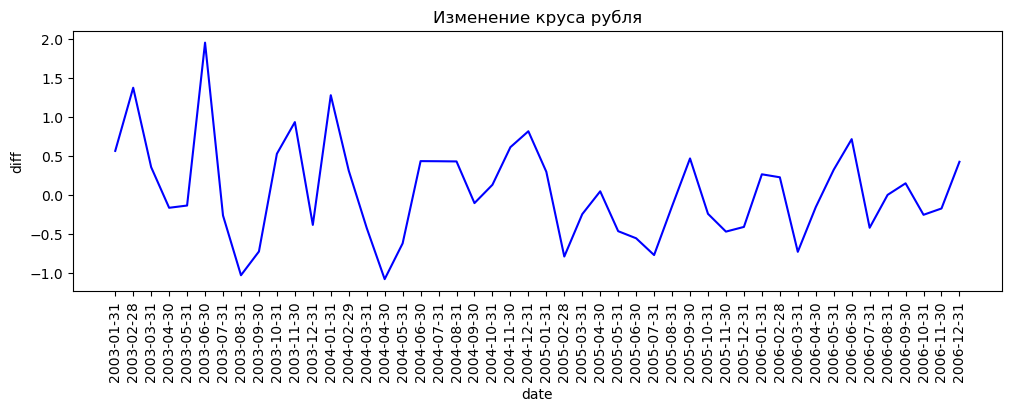

In [32]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='Изменение круса рубля')
ax.plot(raw.date, raw.dif,'b-')
ax.set_xlabel('date')
ax.set_xticks(ticks=raw.date,labels=raw.date,rotation=90)
ax.set_ylabel('diff')

plt.show()

### Проверка гипотезы на случайность выборки

H0: выборка взята из случайного распределения 

Протестируем гипотезу с использованием критерия кендалла, критерия серий и критерия поворотных точек 

#### *Критерий поворотных точек*

In [36]:
 turning_points_test(raw['dif'])

 # наблюдений = 48 
 пики = 11 
 впадины = 11 
 поворотные точки = 22 
 среднее 30.667 
 дисперсия 8.211 
 статистика -3.024


Статистика по модулю равна 3.024 > 1.96 => нулевая гипотеза о случайности выборки **не отвергается**, а именно количество поворотных (22) точек значимо не превышает математическое ожидание (30.667), что приводит к неотвержению гипотезы случайности.

#### *Критерий Кендалла*


In [33]:
results_ret = mk.original_test(raw.dif)

print(' p-value', round(results_ret.p, 3),
      '\n тау Кендалла =', round(results_ret.Tau, 3),
      '\n стандартизированная тау =', round(results_ret.z, 3))

 p-value 0.237 
 тау Кендалла = -0.119 
 стандартизированная тау = -1.182


p-value = 0.237 это больше чем 0.05 => нулевая гипотеза о случайности выборки **не отвергается**

Также принять решение об отвержении/не отвержении гипотезы случайности выборки можно с помощью стандартизированной тау: если стандартизированная тау значимо отличается от нуля, то гипотеза H0 о случайности выборки отвергается.

В нашем случае значение z статистики или стандартизированной тау равно -1.182, те оно лежит в пределах (от -1.96 до 1.96) не отвержения нулевой гипотезы о равенстве z статистики нулю => стандартизированная тау значимо **не** отличается от нуля => гипотеза о случаности выборки **не отвергается**

#### *Критерий серий*

In [39]:
series_test(raw.dif)

 плюсы = 24 
 минусы = 24 
 серии = 23 
 среднее 25.0 
 дисперсия 11.745 
 статистика -0.584


Статистика по модулю равна 0.584 < 1.96 => нулевая гипотеза о случайности выборки **не отвергается**

#### Вывод:на основании всех терх критериев мы не  отвергаем гипотезу о случайности выборки, следовательно выборка взята из случайного распредлелния

### Проверка гипотезы на нормальность

H0: выборка взята из нормального распределения

#### *Критерий Лилиерфорса*

In [34]:
stat.lilliefors(raw.dif, dist='norm')

(0.09623078012651515, 0.3291903621449257)

H0 о нормальности распределения **не отвергается**, тк p-value = 0.3291903621449257 > 0.05

#### *Критерий Андерсона-Дарлинга*

In [35]:
stats.anderson(raw.dif, 'norm')

AndersonResult(statistic=0.3794659014351396, critical_values=array([0.537, 0.612, 0.734, 0.856, 1.018]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.050910726548068906, scale=0.6260656621489562)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Сравниваем значение статистки 0.3794659014351396 c 0.734 для 5% уровня значимости , статистика меньше => H0 о нормальности **не отвергается** 

#### *Критерий Колмогорова-Смирнова*

In [36]:
stats.kstest(raw.dif, 'norm')

KstestResult(statistic=0.17442736760052338, pvalue=0.09525784073551113, statistic_location=-0.7854529114894646, statistic_sign=-1)

p-value=0.095 > 0.05 => нулевую гипотезу о нормальности распределения **не отвергаем**

#### Вывод : все критерии не отвергают нулевую гипотезу о нормальности, следовательно выборка взята из нормального распределения

# Задача 2

В файле z_14.csv приведены значения ряда price (логарифмированных цен на нефть), использованного в статье [Kilian 2009], за период с января 1985 года по декабрь 2003 года включительно.

Нербходимо протестировать этот ряд на **наличие/отсутствие единичного корня**, убрав из выборки последние 9 месяцев, где 9 соответствует вашей фамилии

По результатам тестирования **построить соответствующую DS или TS модель** порождения этого ряда. В случае, если не отвергнуты ни DS-гипотеза, ни TS-гипотеза, построить DS и TS модели порождения этого ряда.

In [7]:
data = pd.read_csv('z_14.csv')

In [8]:
df=data[:-9]['price']

In [9]:
df.head()

0    37
1    34
2    35
3    36
4    36
Name: price, dtype: int64

#### 1. Графический анализ 

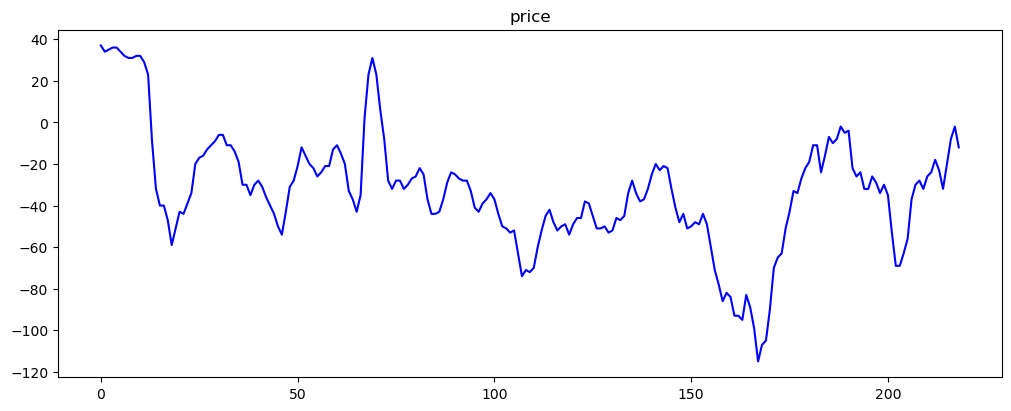

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)

ax.set(title='price')
ax.plot(df,'b-')

plt.show()

На графики выдим константу, возможно есть убывающий тренд 

#### 2. Анализ ряда на наличие отсутстввие единичного корня

Тестирование на гипотезу единичного корня с помощью ADF теста 

In [14]:
print(adf_test(df, 'n').bic) #только константа 

Results of Dickey-Fuller Test:
Test Statistic                  -1.962103
p-value                          0.047540
#Lags Used                       2.000000
Number of Observations Used    216.000000
Critical Value (1%)             -2.576169
Critical Value (5%)             -1.942313
Critical Value (10%)            -1.615646
dtype: float64
1453.5066814317643


In [11]:
print(adf_test(df, 'c').bic) #только константа 

Results of Dickey-Fuller Test:
Test Statistic                  -3.680540
p-value                          0.004395
#Lags Used                       2.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64
1449.2510405467697


In [12]:
print(adf_test(df, 'ct').bic) #константа и тренд 

Results of Dickey-Fuller Test:
Test Statistic                  -4.059846
p-value                          0.007216
#Lags Used                       1.000000
Number of Observations Used    217.000000
Critical Value (1%)             -4.001106
Critical Value (5%)             -3.430919
Critical Value (10%)            -3.139051
dtype: float64
1457.9673190957749


Выводы: по bic (критерию Шварца) лучше модель только с константой и без тренда

In [13]:
print(adf_test(df, 'c').summary())

Results of Dickey-Fuller Test:
Test Statistic                  -3.680540
p-value                          0.004395
#Lags Used                       2.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     28.40
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           1.78e-15
Time:                        21:22:49   Log-Likelihood:                -713.87
No. Observations:                 216   AIC:                             1436.
Df Residuals:                     212   BIC:                             1449.
Df Model:                   

Гипотеза единичнго корня (нулевая гипотеза) отвергается так как p-value= 0.004395 <0.05 

Следовательно перед нами ряд TS 

#### 3. Определение модели DGP 

Также видим, что коэффициент при dy(-2) статистически незначим, можем сразу оценить модель ARMA(2,0,0) в уровнях 

In [15]:
mod_ts = sm.tsa.statespace.SARIMAX(df, trend='c', order=(2,0,0))
res_ts = mod_ts.fit(disp = False)
print(res_ts.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  219
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -729.227
Date:                Tue, 24 Jun 2025   AIC                           1466.455
Time:                        21:24:26   BIC                           1480.011
Sample:                             0   HQIC                          1471.930
                                - 219                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.6386      0.501     -3.272      0.001      -2.620      -0.657
ar.L1          1.4472      0.058     24.788      0.000       1.333       1.562
ar.L2         -0.5016      0.059     -8.488      0.0

Все коэффициенты при переменных значимы, можем выписать модель в уровнях:

$y_t=-1.6386 + 1.4472 y_{t-1} - 0.5016y_{t-2} + u_t$

И для данной модели проведем диагностику остатков 

#### 4. Диагностика остатков 

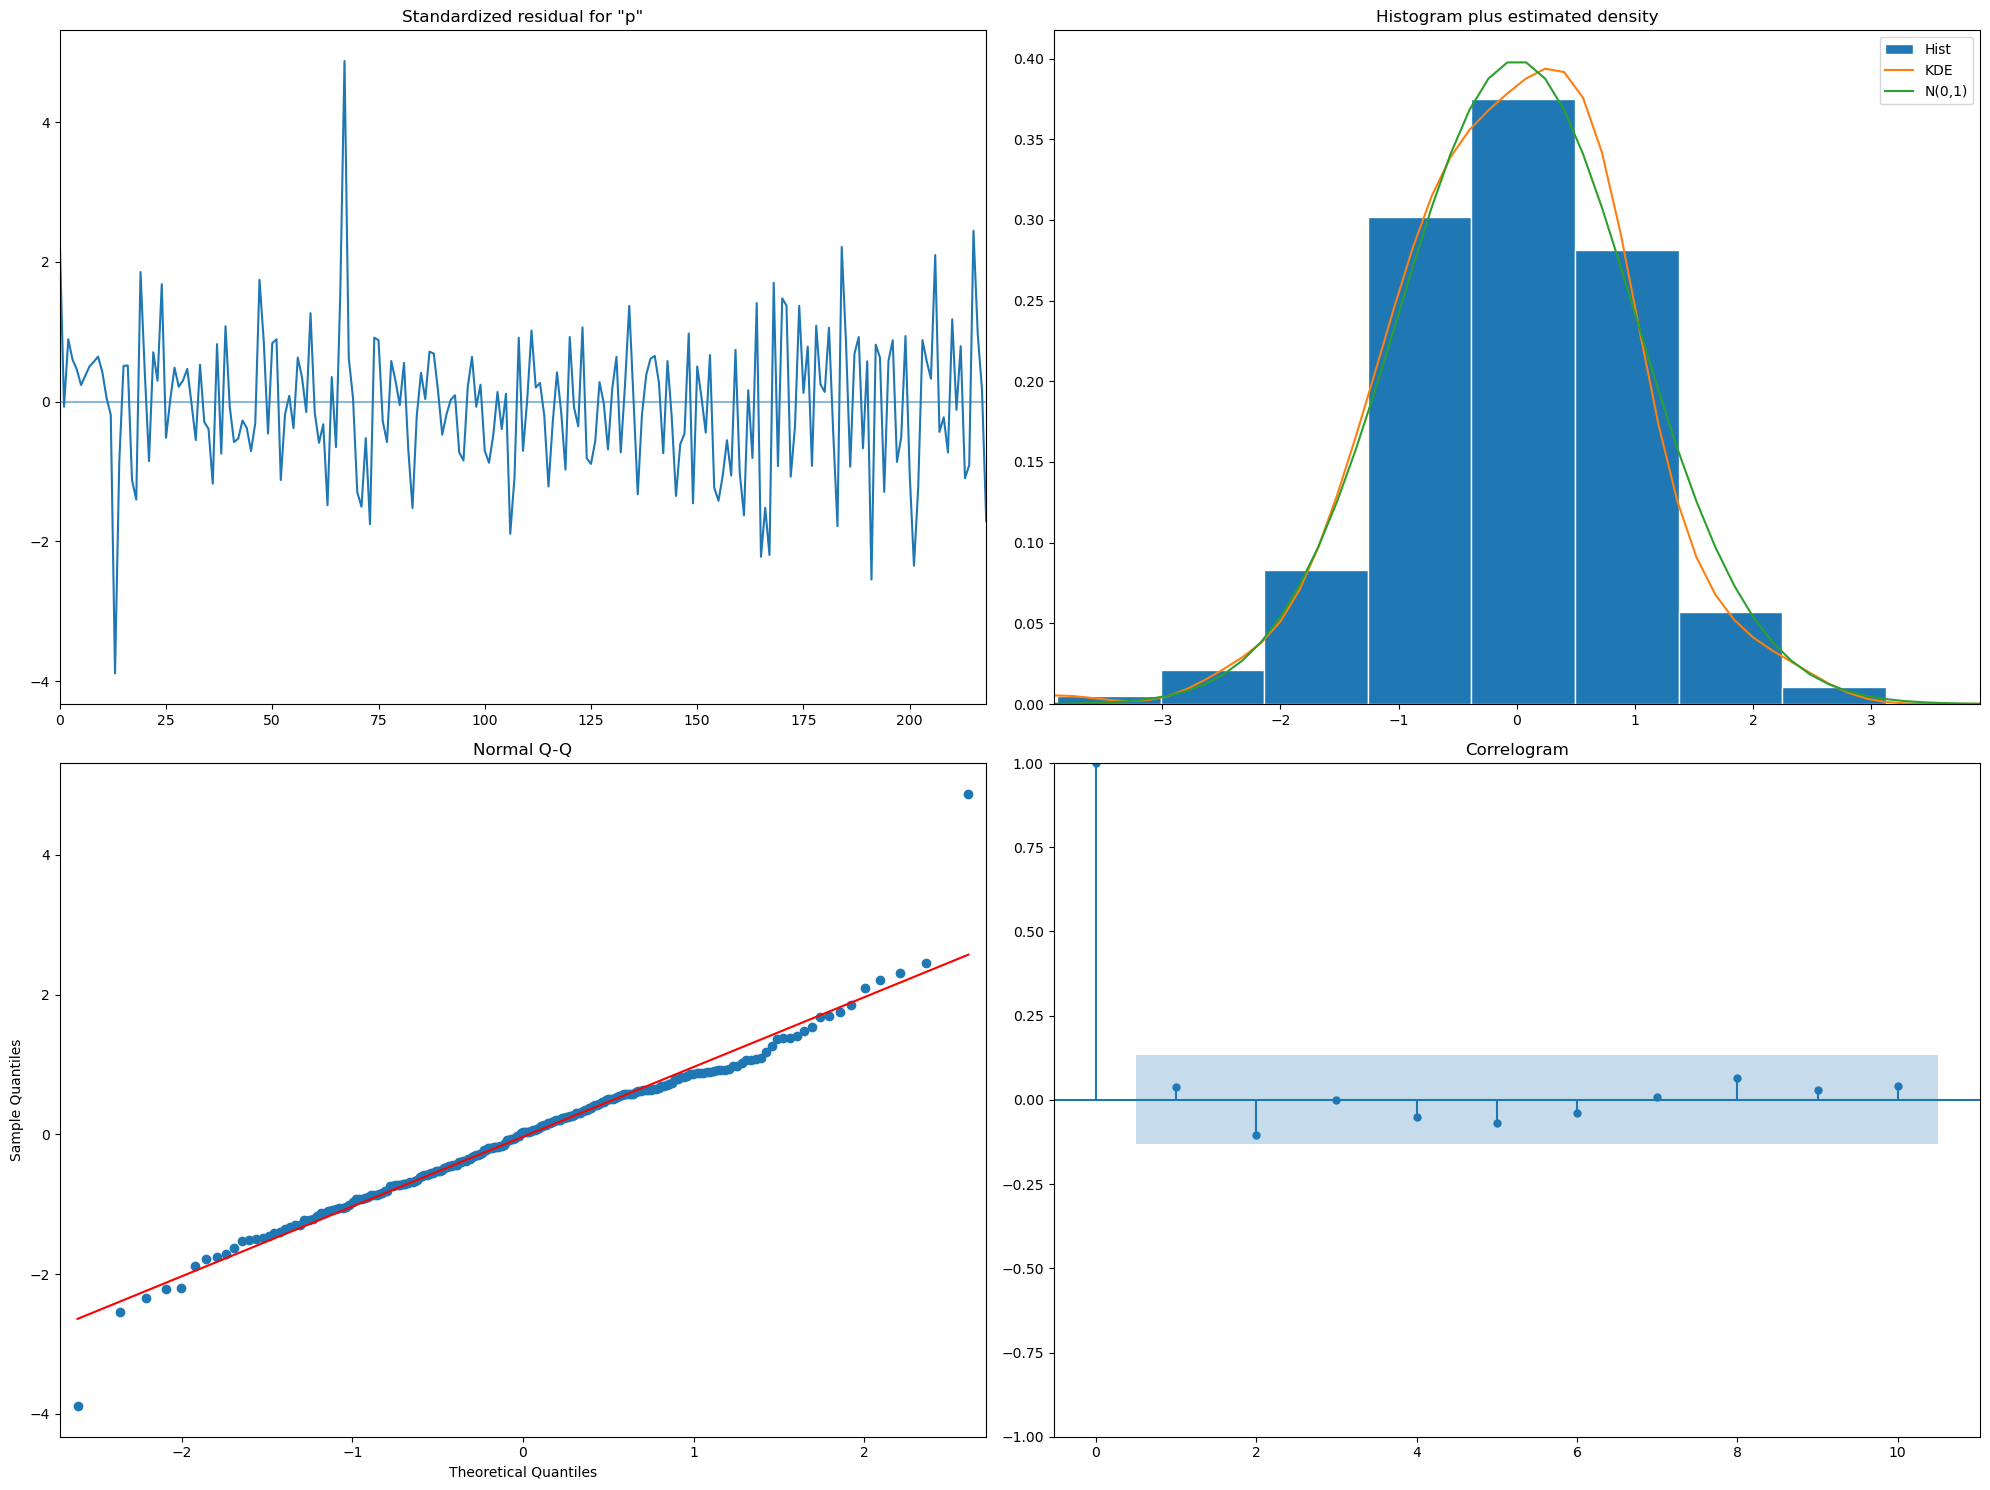

In [17]:
res_ts.plot_diagnostics(figsize=(20, 15))
plt.tight_layout()

In [18]:
# тест Бройша-Годфри
# H0: нет корреляций в остатках
print('p-value =', np.round(bgtest(res_ts, nlags = 5)[1], 3))

p-value = 0.937


Графически остатки выглядят хорошо: на коррелограме корреляции не выходят за пределы доверительного интервала, на графики остатков остатки колеблются около 0 и имеют примерно одинаковую дисперсию => белый шум

По результатам теста Бройдша-Годфри где H0: нет корреляции в остатках p-value=0.937 > 0.05 => гипотза об отстутсвии корреляции в остатках не отвергается , те с остатками все хорошо в них нет корреляции 

Таким образом TS модель порождающая  этот ряд :

$y_t=-1.6386 + 1.4472 y_{t-1} - 0.5016y_{t-2} + u_t$


# Задача 3

В файле z_15.csv приведены значения ряда tavg (среднемесячная температура в городе Долгопрудный) на периоде с января 2003 года по декабрь 2023 года.




In [151]:
data = pd.read_csv('z_15.csv')
data.time=pd.to_datetime(data.time)
date_range = (data.time <= '2019-12-31')

raw= data[date_range]
raw.reset_index(inplace=True,drop=True)

In [152]:
data.set_index('time',inplace=True)

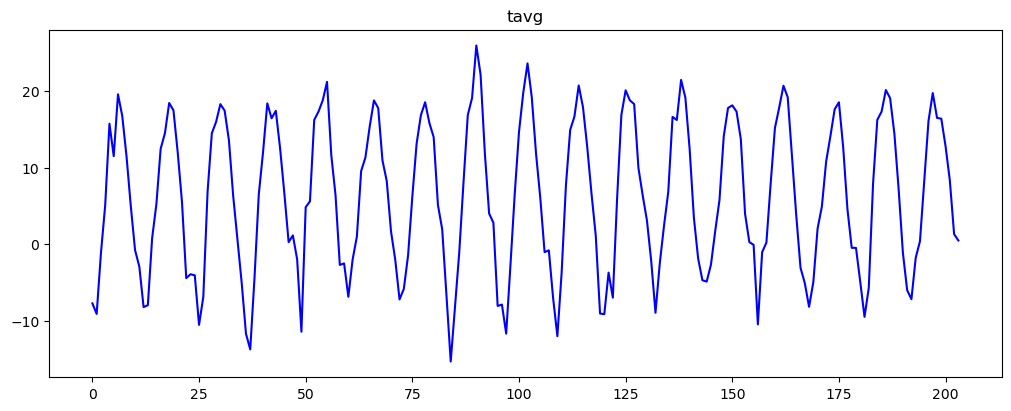

In [153]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)

ax.set(title='tavg')
ax.plot(raw.tavg,'b-')

plt.show()

На графики видим явно выраженную сезонность 

### 1. Применить подходящую процедуру проверки гипотезы единичного корня для этого ряда с явно выраженной сезонностью


In [154]:
raw.time = pd.to_datetime(raw.time, format = '%Y' + '-' + '%m' + '-' + '%d')
raw = raw.set_index('time')

Очистим данные от сезонности и на остатках проведем ADF тест

In [155]:
#создали дамми пременные на сезонность 
dum = pd.get_dummies(raw.index.month, dtype = float)
dum.index = raw.index
# очистка от сезонности 
mod_d = sm.tsa.statespace.SARIMAX(raw.tavg, trend='n', order=(0,0,0), exog = dum)
results_d = mod_d.fit(disp = False)
print(results_d.summary())

                               SARIMAX Results                                
Dep. Variable:                   tavg   No. Observations:                  204
Model:                        SARIMAX   Log Likelihood                -469.559
Date:                Tue, 24 Jun 2025   AIC                            965.118
Time:                        23:41:38   BIC                           1008.253
Sample:                    01-31-2003   HQIC                           982.567
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1             -7.7296      0.485    -15.923      0.000      -8.681      -6.778
2             -6.9606      0.350    -19.888      0.000      -7.647      -6.275
3             -1.2134      0.430     -2.822      0.0

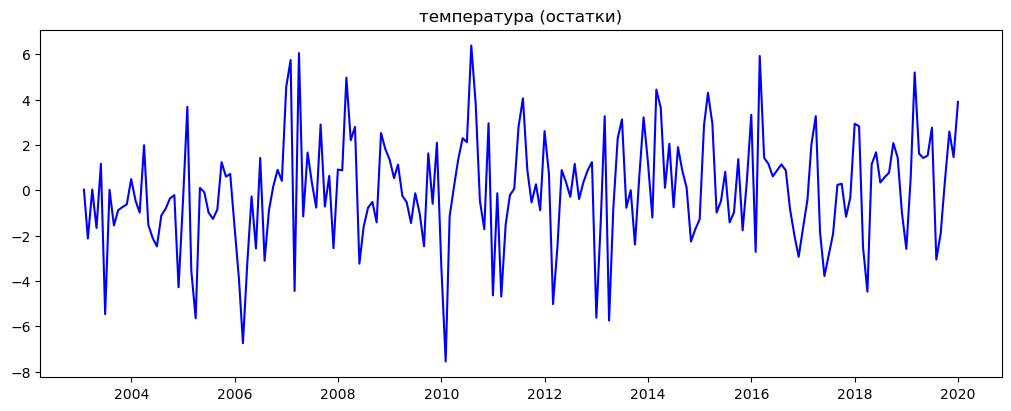

In [156]:
#график остатков 
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 4), constrained_layout=True)

ax.set(title='температура (остатки)')
ax.plot(results_d.resid,'b-')

plt.show()

Нет const, и нет тренда

In [157]:
res_adf_d = adf_test(results_d.resid, 'n')
print(res_adf_d.summary())

Results of Dickey-Fuller Test:
Test Statistic                -1.179527e+01
p-value                        1.782627e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -2.576842e+00
Critical Value (5%)           -1.942401e+00
Critical Value (10%)          -1.615574e+00
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.405
Method:                 Least Squares   F-statistic:                              139.1
Date:                Tue, 24 Jun 2025   Prob (F-statistic):                    9.04e-25
Time:                        23:41:39   Log-Likelihood:                         -464.53
No. Observations:                 203   AIC:                                      931.1
Df Residuals:                 

на основании ADF теста проведенного для остатков модели, которая была очищенна от сезонности с помощью дамми переменных, можем сделать вывод что p-value близко к 0 и следовательно гипотеза о наличии единичного корня отвергается  

### 2. Выберать три модели, устраивающие по информационным критериям и проходящие диагностику остатков


#### Перва модель : без константы и без тренда 

In [158]:
res_adf_1 = adf_test(results_d.resid, 'n')
print(res_adf_1.summary())

Results of Dickey-Fuller Test:
Test Statistic                -1.179527e+01
p-value                        1.782627e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -2.576842e+00
Critical Value (5%)           -1.942401e+00
Critical Value (10%)          -1.615574e+00
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.408
Model:                            OLS   Adj. R-squared (uncentered):              0.405
Method:                 Least Squares   F-statistic:                              139.1
Date:                Tue, 24 Jun 2025   Prob (F-statistic):                    9.04e-25
Time:                        23:41:40   Log-Likelihood:                         -464.53
No. Observations:                 203   AIC:                                      931.1
Df Residuals:                 

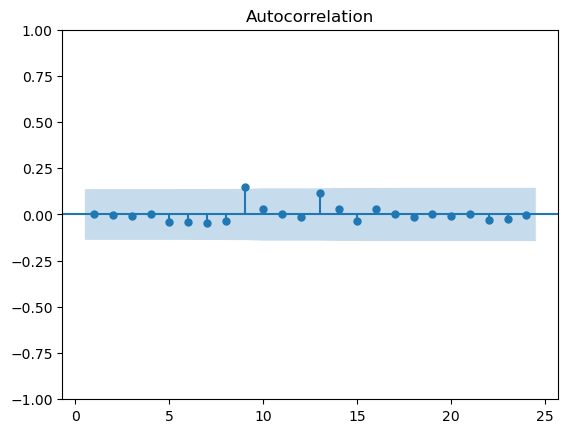

p-value = 0.841


In [159]:
sm.graphics.tsa.plot_acf(res_adf_1.resid, zero = False)
plt.show()
print('p-value =', np.round(bgtest(res_adf_1, nlags = 12)[1], 3))

Диагностика остатков по тесту бройша годфри гипотза об отсутствии автокор в остатках не отвергается по p-value= > все ок 

По ACF корреляции практически не выходят за доверительный интервал (исключение одна корреляции близкая к гарнице интервала) => с остатками все ок

#### Вторая модель: без trend но с константой 

In [160]:
res_adf_2 = adf_test(results_d.resid, 'c')
print(res_adf_2.summary())

Results of Dickey-Fuller Test:
Test Statistic                -1.176552e+01
p-value                        1.121449e-21
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -3.462980e+00
Critical Value (5%)           -2.875885e+00
Critical Value (10%)          -2.574416e+00
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     138.4
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           1.18e-24
Time:                        23:41:42   Log-Likelihood:                -464.53
No. Observations:                 203   AIC:                             933.1
Df Residuals:                     201   BIC:                             939.7
Df Model:     

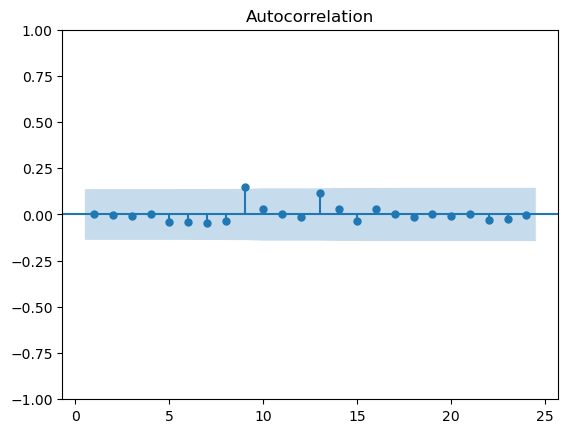

p-value = 0.841


In [161]:
sm.graphics.tsa.plot_acf(res_adf_2.resid, zero = False)
plt.show()
print('p-value =', np.round(bgtest(res_adf_2, nlags = 12)[1], 3))

Диагностика остатков по тесту бройша годфри гипотза об отсутствии автокор в остатках не отвергается (p-value>0.05) = > все ок 

По ACF корреляции практически не выходят за доверительный интервал (исключение одна корреляции близкая к гарнице интервала) => с остатками все ок

#### Третья модель: c константой и трендом

In [162]:
res_adf_3 = adf_test(results_d.resid, 'ct')
print(res_adf_3.summary())

Results of Dickey-Fuller Test:
Test Statistic                -1.205545e+01
p-value                        3.128742e-19
#Lags Used                     0.000000e+00
Number of Observations Used    2.030000e+02
Critical Value (1%)           -4.004072e+00
Critical Value (5%)           -3.432342e+00
Critical Value (10%)          -3.139885e+00
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     72.69
Date:                Tue, 24 Jun 2025   Prob (F-statistic):           1.88e-24
Time:                        23:41:43   Log-Likelihood:                -462.26
No. Observations:                 203   AIC:                             930.5
Df Residuals:                     200   BIC:                             940.5
Df Model:     

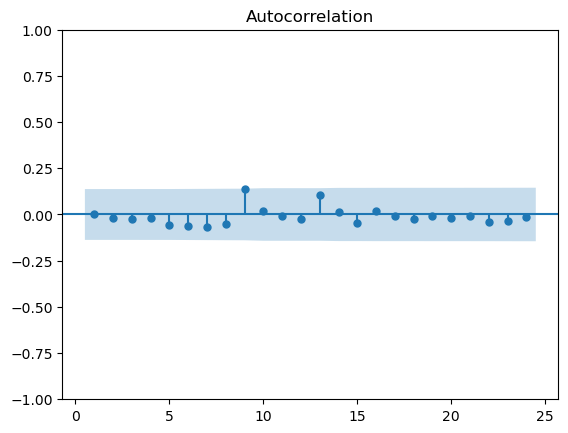

p-value = 0.805


In [163]:
sm.graphics.tsa.plot_acf(res_adf_3.resid, zero = False)
plt.show()
print('p-value =', np.round(bgtest(res_adf_3, nlags = 12)[1], 3))

Диагностика остатков по тесту бройша годфри гипотеза об отсутствии автокореляции в остатках не отвергается (p-value=0.805>0.05) = > все ок 

По ACF корреляции практически не выходят за доверительный интервал (исключение одна корреляции близкая к гарнице интервала) => с остатками все ок

### 3. Выписать уравнение для модели, имеющей наибольший AIC



Модель наибольшая по AIC это модель номер три с константой и трендом  (но константа незначима -1.840 ) и также во избежание дальнейшей мултиколениарности её с дамми мы ее не включаем в модель

Выпишем для нее уравнение в разностях :

$ dy_t = 0.0061t -0.8459y_{t-1} + u_t$  

А теперь в уровнях прибавив к обеим частям $y_{t-1}$

$ y_t = 0.0061t + 0.1541y_{t-1} +u_t$ -> non_dummy модель 

Итоговая модель выглядит как :

$y_t =a_{1}dammy_1 + ...+ a_{12}dammy_{12} +  0.0061t + 0.1541y_{t-1} +u_t$, где $dammy__i$ это сезонные дамми переменые а $a_i$ соотвествующие им коэффициенты оцененные ранее ( для экономии времени коэффиценты не были подствлены, но их оценки у нас есть  )

### 4. Сравнить прогнозные свойства трех моделей по MSE, строя прогнозы на оставшийся кусок выборки

Оценим SARIMA модели, параметры сезонности, а также p и q подберем на основе ACF и PACF исходного ряда

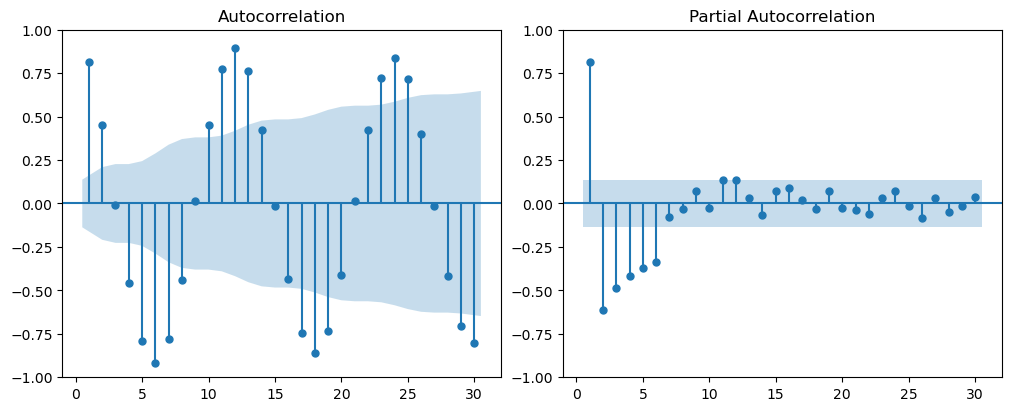

In [164]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(raw.tavg, zero = False,lags=30, ax = ax1)
sm.graphics.tsa.plot_pacf(raw.tavg, method = 'ywm', zero = False, lags = 30, ax = ax2)
plt.show()

по ACF отчетливо выделяется осциллирующее затухание с периодом в 6 лагов

по PACF плавное затухание 6 лагов, затем резкий обрыв => пробуем модель с сезонностью кратной 12 (потому, что данные месячные + если оценивать модель с порядком сезонности (2,0,0,6), то 6й сезонный лаг будет незначим, а 12й значим) и p=6 (тк несезонный обрыв после 6 лага по PACF),q=0

In [195]:
mod_m = sm.tsa.statespace.SARIMAX(raw.tavg, trend='n', order=(6,0,0), seasonal_order=(1,0,0,12))
results = mod_m.fit(disp = False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               tavg   No. Observations:                  204
Model:             SARIMAX(6, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -547.894
Date:                            Tue, 24 Jun 2025   AIC                           1111.789
Time:                                    23:51:19   BIC                           1138.334
Sample:                                01-31-2003   HQIC                          1122.527
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2131      0.068      3.122      0.002       0.079       0.347
ar.L2          0.0314      0.066   

лаги после 1го незначимы => оставляем модель SARMA(1,0,0) с сезонностью (1,0,0,12)

#### Первая модель: без константы и тренда 

In [173]:
mod_m = sm.tsa.statespace.SARIMAX(raw.tavg, trend='n', order=(1,0,0), seasonal_order=(1,0,0,12))
results = mod_m.fit(disp = False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               tavg   No. Observations:                  204
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -548.455
Date:                            Tue, 24 Jun 2025   AIC                           1102.910
Time:                                    23:42:30   BIC                           1112.864
Sample:                                01-31-2003   HQIC                          1106.936
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2080      0.066      3.154      0.002       0.079       0.337
ar.S.L12       0.9341      0.024   

In [174]:
forecast = results.get_forecast(len(data)-len(raw)) 
prediction = results.get_prediction()

data_2 = pd.concat([data, forecast.predicted_mean], axis=1)
data_2.loc[raw.index, 'predicted_mean'] = prediction.predicted_mean

# mse
mse_1=mse(data_2['predicted_mean'][~date_range.values], data_2['tavg'][~date_range.values])

#### Вторая модель с константой и без тренда

In [175]:
mod_m = sm.tsa.statespace.SARIMAX(raw.tavg, trend='c', order=(1,0,0), seasonal_order=(1,0,0,12))
results = mod_m.fit(disp = False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               tavg   No. Observations:                  204
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -545.105
Date:                            Tue, 24 Jun 2025   AIC                           1098.211
Time:                                    23:42:33   BIC                           1111.483
Sample:                                01-31-2003   HQIC                          1103.580
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4564      0.166      2.746      0.006       0.131       0.782
ar.L1          0.2094      0.065   

In [176]:
forecast = results.get_forecast(len(data)-len(raw)) 
prediction = results.get_prediction()

data_2 = pd.concat([data, forecast.predicted_mean], axis=1)
data_2.loc[raw.index, 'predicted_mean'] = prediction.predicted_mean

# mse
mse_2=mse(data_2['predicted_mean'][~date_range.values], data_2['tavg'][~date_range.values])

#### Третья модель с константой и с трендом 

In [177]:
mod_m = sm.tsa.statespace.SARIMAX(raw.tavg, trend='ct', order=(1,0,0), seasonal_order=(1,0,0,12))
results = mod_m.fit(disp = False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               tavg   No. Observations:                  204
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -544.883
Date:                            Tue, 24 Jun 2025   AIC                           1099.765
Time:                                    23:43:16   BIC                           1116.356
Sample:                                01-31-2003   HQIC                          1106.476
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3803      0.210      1.814      0.070      -0.031       0.791
drift          0.0016      0.003   

In [178]:
forecast = results.get_forecast(len(data)-len(raw)) 
prediction = results.get_prediction()

data_2 = pd.concat([data, forecast.predicted_mean], axis=1)
data_2.loc[raw.index, 'predicted_mean'] = prediction.predicted_mean

# mse
mse_3=mse(data_2['predicted_mean'][~date_range.values], data_2['tavg'][~date_range.values])

### Сравнение полученных результатов

In [188]:
print(f"без константы и без тренда :", mse_1,"\n", 
      f"с константой и без тренда :", mse_2,"\n",
      f"с константой и c трендом :", mse_3)

без константы и без тренда : 14.54489429646207 
 с константой и без тренда : 16.7677407704349 
 с константой и c трендом : 18.57530347315049


По итогам оценивания лучшая модель без константы и без тренда, тк она имеет наименьший MSE

# Задача 4

В файле z_16.csv приведены ряды x1–x15, имеющие структурный излом. Датировка момента излома T=51 экзогенная.

In [196]:
data = pd.read_csv('z_16.csv')

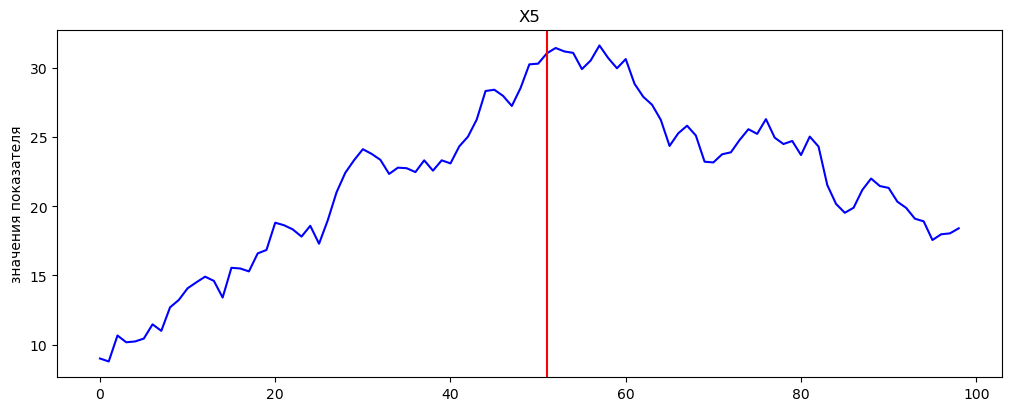

In [210]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

ax.set(title='X5')
ax.plot(data['X5'] ,'b-')
ax.axvline(x=51,color='red')
ax.set_ylabel('значения показателя')

plt.show()


Считая структурный сдвиг инновационным, применить **тест Перрона** для проверки гипотезы единичного корня в модели сегментированного тренда для ряда X5.

В соответствии с результатами проверки **построить подходящую модель** порождения этого ряда.

Статистическая модель сегментированного тренда (SM): $x_t=c+βt+γDTS_t+αx_{t-1}+e_t$ где $DTS_t=t-T_B$, при $t>T_B$ и $DTS_t=0$, при $t<=T_B$  ; $T_B$ - момент излома

In [198]:
# столбец приращений ВВП
data['drgdp'] = data['X5'].diff(1) #xt-x(t-1)

# столбец лагов приращений ВВП
data['drgdp(-1)'] = data['drgdp'].shift(1)
data['drgdp(-2)'] = data['drgdp'].shift(2)


# столбец лагов ВВП
data['rgdp(-1)'] = data['X5'].shift(1)
data['rgdp(-2)'] = data['X5'].shift(2)

In [199]:
### Для построения дамми-переменных

# столбец тренда:
data['t'] = np.arange(1,len(data['X5']) + 1)

# столбец дамми тренда:
data['dts'] = np.r_[np.zeros(51), np.arange(1,len(data['X5']) - 51 + 1)]

# столбец дамми сдвига:
data['du'] = np.r_[np.zeros(51), np.ones(len(data['X5']) - 51)]

Оценим статистическую модель для инновационного сдвига, в модели сегментированного тренда

In [200]:
mod_perron = sm.regression.linear_model.OLS(data['drgdp'][2:],
                                            exog = sm.add_constant(data[['t', 'dts', 'rgdp(-1)',]])[2:])
res_perron = mod_perron.fit()
print(res_perron.summary())

                            OLS Regression Results                            
Dep. Variable:                  drgdp   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     10.07
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           8.29e-06
Time:                        20:16:26   Log-Likelihood:                -123.08
No. Observations:                  97   AIC:                             254.2
Df Residuals:                      93   BIC:                             264.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6750      0.540      4.954      0.0

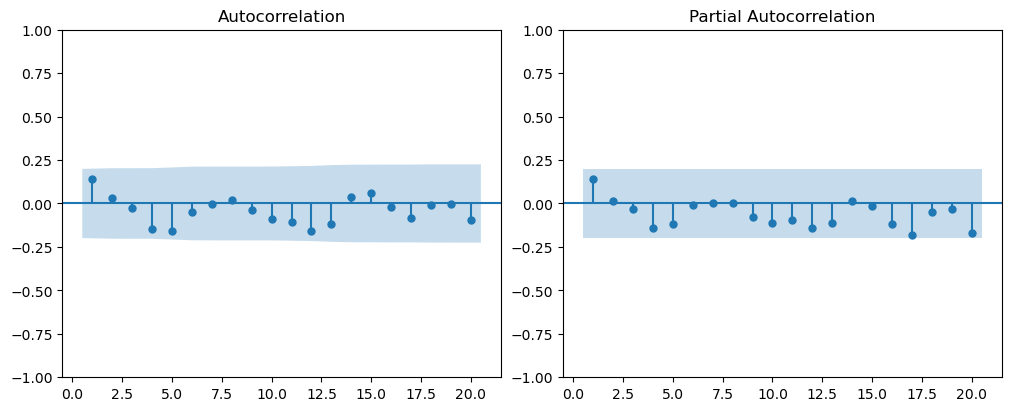

p-value = 0.348


In [201]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res_perron.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res_perron.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()
print('p-value =', np.round(bgtest(res_perron, nlags = 5)[1], 3))

Нет корреляции в остатках на основани  графического анализа и теста Бройша-Годфри

Оценим ту же самую модель, но с добавлением одной запаздывающей разности (спойлер: она оказалась статистически незначима)

In [202]:
mod_perron = sm.regression.linear_model.OLS(data['drgdp'][2:],
                                            exog = sm.add_constant(data[['t', 'dts', 'rgdp(-1)', 'drgdp(-1)']])[2:])
res_perron = mod_perron.fit()
print(res_perron.summary())

                            OLS Regression Results                            
Dep. Variable:                  drgdp   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     8.338
Date:                Thu, 26 Jun 2025   Prob (F-statistic):           8.75e-06
Time:                        20:17:01   Log-Likelihood:                -121.72
No. Observations:                  97   AIC:                             253.4
Df Residuals:                      92   BIC:                             266.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7728      0.539      5.147      0.0

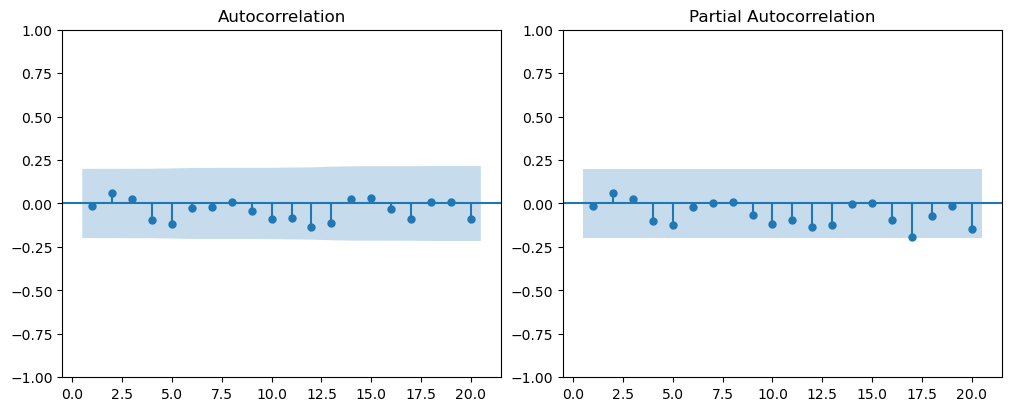

p-value = 0.617


In [203]:
fig, [ax1,ax2] = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4), constrained_layout=True)

sm.graphics.tsa.plot_acf(res_perron.resid, zero = False, ax = ax1)
sm.graphics.tsa.plot_pacf(res_perron.resid, method = 'ywm', zero = False, ax = ax2)
plt.show()
print('p-value =', np.round(bgtest(res_perron, nlags = 5)[1], 3))

С остатками все хорошо, они не автокоррелированны, но еще одна запаздывающая разность оказалась незначимой

In [213]:
#только для просмотра критических значений
res_adf_d = adf_test(data['X5'], 'ct')

Results of Dickey-Fuller Test:
Test Statistic                 -0.806236
p-value                         0.965153
#Lags Used                      0.000000
Number of Observations Used    98.000000
Critical Value (1%)            -4.054251
Critical Value (5%)            -3.456279
Critical Value (10%)           -3.153866
dtype: float64


Критическое значение для 5 % уровня значимости -3.456279, смотрим на статистику коэффицента при rgdp(-1): у обеих моделей статистика теста меньше критического значения (для 1й модели:-4.314 и для второй: -4.608) следовательно нулевая гипотеза о наличии единичного корня отвергается. 

Можем выписать модель (первую оцененную) тк там все коэффиценты значимы:

В разностях: 
$dx_t= 2.675 +  0.1095t -0.1855DTS_t - 0.2682x_{t-1} +u_t$

В уровнях:
$x_t= 2.675 +  0.1095t -0.1855DTS_t + 0.7318x_{t-1} +u_t$
